In [ ]:
# ==========================================
# BLOCK 1: IMPORTS & CONFIGURATION
# ==========================================
import os
import shutil
import zipfile
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from google.colab import files
import datetime

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix

# --- Configuration ---
# Detect if we have a GPU available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device set to: {DEVICE}")

# Hyperparameters & Constants
BATCH_SIZE = 32
IMG_SIZE = (128, 128)  # Resize all images to this standard size
SEED = 42
torch.manual_seed(SEED)

# Paths
MERGED_DIR = "./merged_dataset" # Where we will combine all images

✅ Device set to: cpu


In [ ]:
# ==========================================
# BLOCK 2: DOWNLOAD & UNZIP DATA
# ==========================================
from zipfile import ZipFile

# 1. Install Kaggle
!pip install -q kaggle

# 2. Set your credentials (PLEASE FILL THESE IN)
os.environ['KAGGLE_USERNAME'] = "shaguns26"
os.environ['KAGGLE_KEY'] = "KGAT_c1b5e7ad968012914288a27c0fa1766e"

# 3. Download the datasets
print("Downloading Datasets...")
#!kaggle datasets download -d abdallahalidev/plantvillage-dataset
!kaggle datasets download -d abdulahad0296/indoor-plant-disease-detection-dataset

# 4. Unzip the files
print("Unzipping Datasets...")
#!unzip -q plantvillage-dataset.zip
!unzip -q indoor-plant-disease-detection-dataset.zip

# 5. Verify it worked
print("✅ files downloaded and unzipped. Current directory:")
!ls

Dataset URL: https://www.kaggle.com/datasets/abdulahad0296/indoor-plant-disease-detection-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
indoor-plant-disease-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Unzipping Datasets...
replace indoor/test/Aloe_Anthracnose/Augmented_0_1006.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
✅ files downloaded and unzipped. Current directory:
indoor	indoor-plant-disease-detection-dataset.zip  merged_dataset  sample_data


In [ ]:
# ==========================================
# BLOCK 3: FILTER & MERGE DATASETS
# ==========================================
def merge_and_filter_datasets():
    # 1. Define the whitelist & renaming logic
    target_classes = {
        # --- PlantVillage ---
        'Apple___Black_rot': 'Apple__Black_Rot',
        'Apple___healthy': 'Apple__Healthy',
        'Apple___Apple_scab': 'Apple__Scab',
        'Apple___Cedar_apple_rust': 'Apple__Rust',
        'Cherry_(including_sour)___Powdery_mildew': 'Cherry__Powdery_Mildew',
        'Cherry_(including_sour)___healthy': 'Cherry__Healthy',
        'Pepper,_bell___Bacterial_spot': 'Pepper__Bacterial_Spot',
        'Pepper,_bell___healthy': 'Pepper__Healthy',
        'Strawberry___Leaf_scorch': 'Strawberry__Scorch',
        'Strawberry___healthy': 'Strawberry__Healthy',
        'Tomato___Early_blight': 'Tomato__Early_Blight',
        'Tomato___Late_blight': 'Tomato__Late_Blight',
        'Tomato___healthy': 'Tomato__Healthy',

        --- Indoor Plants ---
        'Aloe_Anthracnose': 'Aloe_Vera__Anthracnose',
        'Aloe_Healthy': 'Aloe_Vera__Healthy',
        'Aloe_LeafSpot': 'Aloe_Vera__LeafSpot',
        'Aloe_Rust': 'Aloe_Vera__Rust',
        'Aloe_Sunburn': 'Aloe_Vera__Sunburn',
        'Cactus_Dactylopius_Opuntia': 'Cactus__Dactylopius_Opuntia',
        'Cactus_Healthy': 'Cactus__Healthy',
        'Money_Plant_Bacterial_wilt_disease': 'Money_Plant__Bacterial_wilt_disease',
        'Money_Plant_Healthy': 'Money_Plant__Healthy',
        'Money_Plant_Manganese_Toxicity': 'Money_Plant__Manganese_Toxicity',
        'Snake_Plant_Anthracnose': 'Snake_Plant__Anthracnose',
        'Snake_Plant_Healthy': 'Snake_Plant__Healthy',
        'Snake_Plant_Leaf_Withering': 'Snake_Plant__Leaf_Withering',
        'Spider_Plant_Fungal_leaf_spot': 'Spider_Plant__Fungal_leaf_spot',
        'Spider_Plant_Healthy': 'Spider_Plant__Healthy',
        'Spider_Plant_Leaf_Tip_Necrosis': 'Spider_Plant__Leaf_Tip_Necrosis',
    }

    # 2. Reset the merged directory
    if os.path.exists(MERGED_DIR):
        shutil.rmtree(MERGED_DIR)
    os.makedirs(MERGED_DIR)

    print(f"Filtering datasets...")

    count = 0
    # Walk through the current directory to find raw class folders
    for root, dirs, _ in os.walk("."):
        # Skip the output folder and hidden system folders
        if "merged_dataset" in root or ".git" in root:
            continue

        for d in dirs:
            # CHECK: Is this folder in our target list?
            if d in target_classes:
                # Logic: Found a match!
                original_path = os.path.join(root, d)
                new_name = target_classes[d]
                dest_path = os.path.join(MERGED_DIR, new_name)

                # Copy logic
                if not os.path.exists(dest_path):
                    shutil.copytree(original_path, dest_path)
                    count += 1
                else:
                    # If folder exists (rare overlap), merge files
                    for file in os.listdir(original_path):
                        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                            shutil.copy2(os.path.join(original_path, file), os.path.join(dest_path, file))

                print(f"  -> Merged: {d}  ==>  {new_name}")

    print(f"\n✅ Successfully filtered & merged {count} classes into '{MERGED_DIR}'")

# Run the new logic
merge_and_filter_datasets()

Filtering datasets...
  -> Merged: Snake_Plant_Leaf_Withering  ==>  Snake_Plant__Leaf_Withering
  -> Merged: Money_Plant_Healthy  ==>  Money_Plant__Healthy
  -> Merged: Money_Plant_Manganese_Toxicity  ==>  Money_Plant__Manganese_Toxicity
  -> Merged: Spider_Plant_Fungal_leaf_spot  ==>  Spider_Plant__Fungal_leaf_spot
  -> Merged: Spider_Plant_Leaf_Tip_Necrosis  ==>  Spider_Plant__Leaf_Tip_Necrosis
  -> Merged: Spider_Plant_Healthy  ==>  Spider_Plant__Healthy
  -> Merged: Snake_Plant_Anthracnose  ==>  Snake_Plant__Anthracnose
  -> Merged: Snake_Plant_Healthy  ==>  Snake_Plant__Healthy
  -> Merged: Money_Plant_Bacterial_wilt_disease  ==>  Money_Plant__Bacterial_wilt_disease
  -> Merged: Snake_Plant_Leaf_Withering  ==>  Snake_Plant__Leaf_Withering
  -> Merged: Money_Plant_Healthy  ==>  Money_Plant__Healthy
  -> Merged: Money_Plant_Manganese_Toxicity  ==>  Money_Plant__Manganese_Toxicity
  -> Merged: Spider_Plant_Fungal_leaf_spot  ==>  Spider_Plant__Fungal_leaf_spot
  -> Merged: Spider_Plan

In [ ]:
# ==========================================
# BLOCK 4: DATA LOADING & TRANSFORMS
# ==========================================
def get_data_loaders(data_dir, batch_size):
    # Standardize images: Resize -> Tensor -> Normalize
    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        full_dataset = datasets.ImageFolder(data_dir, transform=transform)
    except FileNotFoundError:
        print("❌ Error: Merged dataset folder not found. Did Block 3 run?")
        return None, None, []

    # Split 80% Train, 20% Validation
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, full_dataset.classes

# Initialize Loaders
train_loader, val_loader, class_names = get_data_loaders(MERGED_DIR, BATCH_SIZE)
print(f"Classes Found: {len(class_names)}")

Classes Found: 9


In [ ]:
# ==========================================
# BLOCK 5: CUSTOM CNN ARCHITECTURE
# ==========================================
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()

        # Block 1: Conv -> ReLU -> Pool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Flatten Dimension Calculation:
        # Input 128x128 -> Pool(2) -> 64 -> Pool(2) -> 32 -> Pool(2) -> 16
        # Final shape: 128 channels * 16 * 16
        self.flatten_dim = 128 * 16 * 16

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.flatten_dim, 512)
        self.dropout = nn.Dropout(0.5) # Prevents overfitting
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, self.flatten_dim) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# ==========================================
# BLOCK 6: TRAINING ENGINE (WITH EARLY STOPPING)
# ==========================================
import copy

def train_engine(model, train_loader, val_loader, criterion, optimizer, epochs, model_name="Model", patience=3):
    print(f"\n--- Start Time {datetime.datetime.now()} ---")
    print(f"\n--- Training {model_name} (Max Epochs: {epochs}, Patience: {patience}) ---")
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict()) # Save the best weights

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels) # Calculate Validation Loss
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_acc = 100 * correct / total

        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f"At {datetime.datetime.now()} Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # --- Early Stopping Logic ---
        # We look for MINIMUM validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict()) # Save this model state
            patience_counter = 0 # Reset counter
        else:
            patience_counter += 1
            print(f"   -> No improvement in Val Loss. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"🛑 Early Stopping triggered! Stopping training.")
                break

    # Load the best weights found during training before returning
    model.load_state_dict(best_model_wts)
    print("✅ Loaded best model weights based on Validation Loss.")

    return history

In [ ]:
# ==========================================
# BLOCK 6.5: EVALUATION FUNCTION (ACCURACY & VISUALS)
# ==========================================
def evaluate_model_performance(model, loader, classes, model_name="Model"):
    print(f"\n📊 EVALUATION REPORT: {model_name}")
    print("-" * 40)

    model.eval()
    correct = 0
    total = 0

    # Dictionary to store one example per class: {class_name: (image, pred_idx, true_idx)}
    class_examples = {}

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect one example for every class found in this batch
            for i in range(len(labels)):
                label_idx = labels[i].item()
                class_name = classes[label_idx]

                # Only save if we haven't seen this class yet
                if class_name not in class_examples:
                    class_examples[class_name] = (images[i].cpu(), predicted[i].item(), label_idx)

            # Optional: Stop early if we found all classes (saves time)
            if len(class_examples) == len(classes):
                break

    # 1. Check Accuracy
    accuracy = 100 * correct / total
    print(f"✅ Final Test Accuracy: {accuracy:.2f}%")

    # 2. Visual Predictions (One Per Class)
    print(f"\n🖼️ Visual Predictions (One Example Per Class):")

    # Sort classes alphabetically for clean display
    sorted_classes = sorted(class_examples.keys())

    # Dynamic Grid Calculation
    cols = 5
    rows = (len(sorted_classes) + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))

    for idx, class_name in enumerate(sorted_classes):
        img_tensor, pred_idx, true_idx = class_examples[class_name]

        # Un-normalize for display (Tensor -> Image)
        img = img_tensor.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)

        ax = plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)

        # Green title = Correct, Red title = Wrong
        is_correct = (pred_idx == true_idx)
        color = 'green' if is_correct else 'red'

        # Show Prediction vs Truth
        title_text = f"True: {class_name}\nPred: {classes[pred_idx]}"
        plt.title(title_text, color=color, fontsize=9, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    return accuracy

In [ ]:
# ==========================================
# BLOCK 7: TRAIN MODEL 1 (BASELINE)
# ==========================================
# 1. Initialize
model_1 = PlantDiseaseCNN(num_classes=len(class_names)).to(DEVICE)

# 2. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)

# 3. Train
print("Starting Baseline Training...")
# Set epochs higher (e.g., 20) and let Early Stopping handle the cut-off
history_1 = train_engine(model_1, train_loader, val_loader, criterion, optimizer_1, epochs=20, patience=3, model_name="Model 1 (Baseline)")

# 4. Save
torch.save(model_1.state_dict(), "model_1_baseline.pth")
print("✅ Model 1 Saved.")
files.download("model_1_baseline.pth")

Starting Baseline Training...

--- Start Time 2025-12-06 17:00:43.031545 ---

--- Training Model 1 (Baseline) (Max Epochs: 20, Patience: 3) ---
At 2025-12-06 17:01:02.207986 Epoch [1/20] Train Loss: 1.7917 | Val Loss: 1.4320 | Val Acc: 48.76%
At 2025-12-06 17:01:20.965538 Epoch [2/20] Train Loss: 1.2108 | Val Loss: 1.1739 | Val Acc: 55.92%
At 2025-12-06 17:01:39.188688 Epoch [3/20] Train Loss: 0.9517 | Val Loss: 1.0061 | Val Acc: 60.33%
At 2025-12-06 17:01:57.636330 Epoch [4/20] Train Loss: 0.7666 | Val Loss: 0.9135 | Val Acc: 65.29%
At 2025-12-06 17:02:15.790540 Epoch [5/20] Train Loss: 0.6740 | Val Loss: 0.8443 | Val Acc: 68.32%
At 2025-12-06 17:02:33.964603 Epoch [6/20] Train Loss: 0.5504 | Val Loss: 0.7742 | Val Acc: 71.90%
At 2025-12-06 17:02:52.740193 Epoch [7/20] Train Loss: 0.4027 | Val Loss: 0.7769 | Val Acc: 68.87%
   -> No improvement in Val Loss. Patience: 1/3
At 2025-12-06 17:03:11.740582 Epoch [8/20] Train Loss: 0.3278 | Val Loss: 0.8233 | Val Acc: 71.90%
   -> No improve

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Starting Grid Search ---

Testing: LR=0.001, Batch Size=32

--- Start Time 2025-12-06 04:05:48.869729 ---

--- Training GridSearch_0.001_32 (Max Epochs: 5, Patience: 3) ---
At 2025-12-06 04:16:45.490548 Epoch [1/5] Train Loss: 1.2396 | Val Loss: 0.7317 | Val Acc: 72.73%
At 2025-12-06 04:27:39.243537 Epoch [2/5] Train Loss: 0.7583 | Val Loss: 0.6239 | Val Acc: 76.93%
At 2025-12-06 04:38:26.277430 Epoch [3/5] Train Loss: 0.5961 | Val Loss: 0.5478 | Val Acc: 80.43%
At 2025-12-06 04:49:22.836391 Epoch [4/5] Train Loss: 0.4809 | Val Loss: 0.5207 | Val Acc: 82.03%
At 2025-12-06 05:00:12.105614 Epoch [5/5] Train Loss: 0.3986 | Val Loss: 0.5359 | Val Acc: 82.28%
   -> No improvement in Val Loss. Patience: 1/3
✅ Loaded best model weights based on Validation Loss.

Testing: LR=0.001, Batch Size=64

--- Start Time 2025-12-06 05:00:12.366201 ---

--- Training GridSearch_0.001_64 (Max Epochs: 5, Patience: 3) ---
At 2025-12-06 05:10:59.586140 Epoch [1/5] Train Loss: 1.2573 | Val Loss: 0.8045 | 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🏆 Analyzing Best Optimized Model (Params: {'lr': 0.001, 'batch_size': 64})...

📊 EVALUATION REPORT: Model 2 (Optimized)
----------------------------------------
✅ Final Test Accuracy: 91.15%

🖼️ Visual Predictions (One Example Per Class):


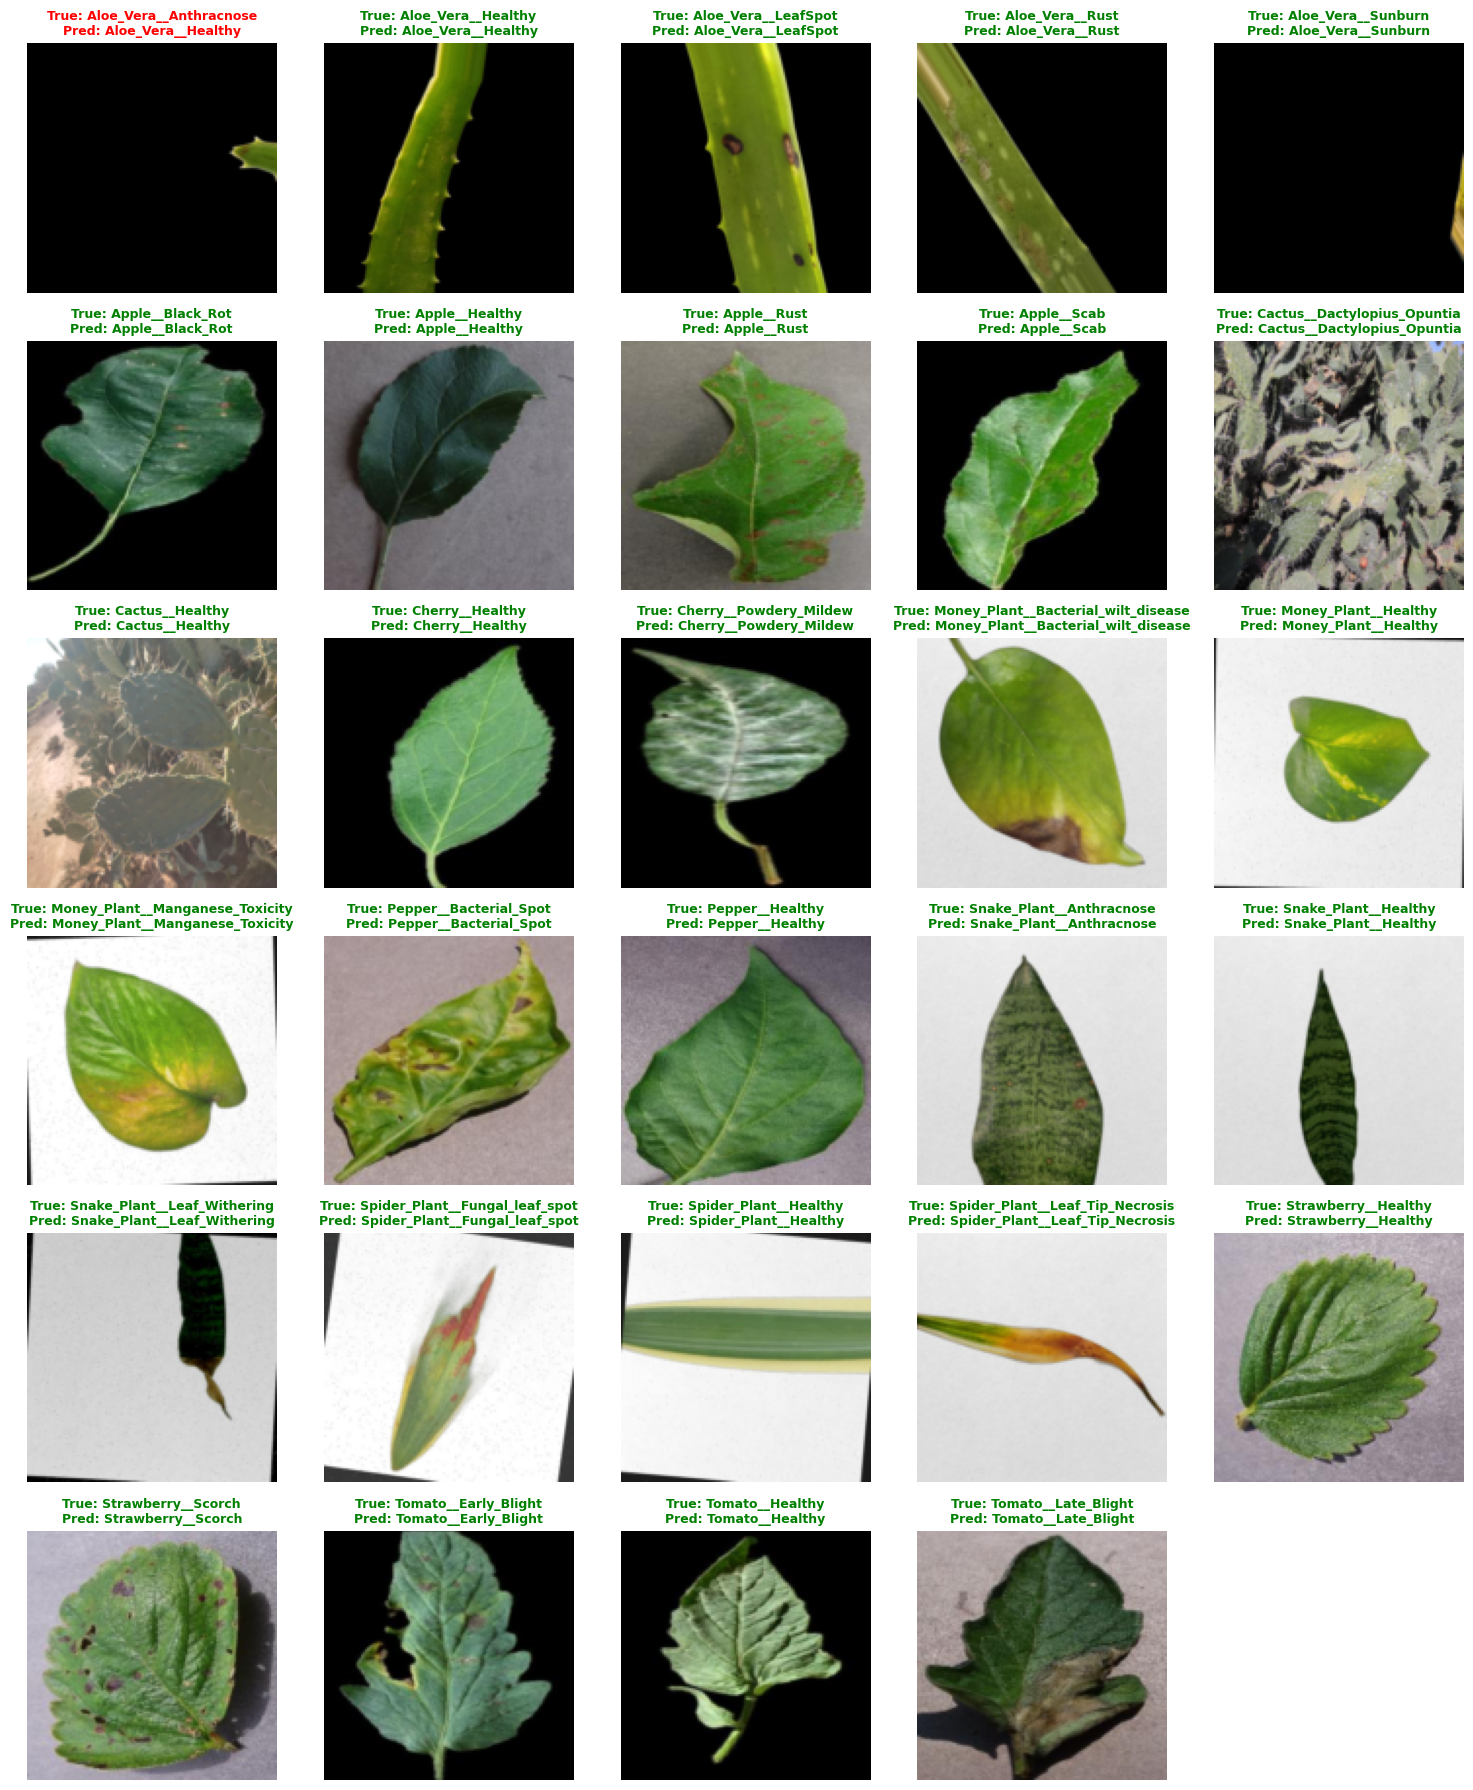

In [ ]:
# ==========================================
# BLOCK 8: GRID SEARCH (MODEL 2 OPTIMIZATION)
# ==========================================
def custom_grid_search():
    # We will try 2 learning rates and 2 batch sizes
    lrs = [0.001, 0.0001]
    batch_sizes = [32, 64]

    best_acc = 0
    best_params = {}
    best_model_state = None

    print("\n--- Starting Grid Search ---")

    for lr in lrs:
        for bs in batch_sizes:
            print(f"\nTesting: LR={lr}, Batch Size={bs}")

            # Re-initialize loaders for batch size change
            t_loader, v_loader, _ = get_data_loaders(MERGED_DIR, bs)

            # Initialize fresh model
            temp_model = PlantDiseaseCNN(len(class_names)).to(DEVICE)
            temp_opt = optim.Adam(temp_model.parameters(), lr=lr)

            # Short training (3 epochs) to test settings
            hist = train_engine(temp_model, t_loader, v_loader, criterion, temp_opt, epochs=5, model_name=f"GridSearch_{lr}_{bs}")

            final_acc = hist['val_acc'][-1]

            if final_acc > best_acc:
                best_acc = final_acc
                best_params = {'lr': lr, 'batch_size': bs}
                best_model_state = temp_model.state_dict()

    print(f"\n✅ Best Params Found: {best_params} with Acc: {best_acc:.2f}%")
    return best_model_state, best_params, best_acc

# Run Search
best_state, best_params, best_acc = custom_grid_search()

# Load best weights into Model 2
model_2 = PlantDiseaseCNN(len(class_names)).to(DEVICE)
model_2.load_state_dict(best_state)
torch.save(model_2.state_dict(), "model_2_optimized.pth")
files.download("model_2_optimized.pth")

# EVALUATE
print(f"\n🏆 Analyzing Best Optimized Model (Params: {best_params})...")
acc_2 = evaluate_model_performance(model_2, val_loader, class_names, "Model 2 (Optimized)")

In [ ]:
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Classes: {len(class_names)}")

Training batches: 46
Validation batches: 12
Classes: 9


Loading Pre-trained ResNet50...

--- Start Time 2025-12-06 16:49:37.109295 ---

--- Training Model 3 (ResNet) (Max Epochs: 20, Patience: 3) ---
At 2025-12-06 16:50:10.438564 Epoch [1/20] Train Loss: 1.5168 | Val Loss: 1.0228 | Val Acc: 80.99%
At 2025-12-06 16:50:42.720107 Epoch [2/20] Train Loss: 0.8152 | Val Loss: 0.7024 | Val Acc: 87.88%
At 2025-12-06 16:51:16.098520 Epoch [3/20] Train Loss: 0.5799 | Val Loss: 0.5640 | Val Acc: 88.15%
At 2025-12-06 16:51:48.000579 Epoch [4/20] Train Loss: 0.4661 | Val Loss: 0.4834 | Val Acc: 91.74%
At 2025-12-06 16:52:22.260276 Epoch [5/20] Train Loss: 0.3715 | Val Loss: 0.4331 | Val Acc: 90.08%
At 2025-12-06 16:52:56.439791 Epoch [6/20] Train Loss: 0.3265 | Val Loss: 0.3873 | Val Acc: 92.01%
At 2025-12-06 16:53:29.988783 Epoch [7/20] Train Loss: 0.2698 | Val Loss: 0.3596 | Val Acc: 92.29%
At 2025-12-06 16:54:03.229561 Epoch [8/20] Train Loss: 0.2403 | Val Loss: 0.3362 | Val Acc: 92.56%
At 2025-12-06 16:54:35.709883 Epoch [9/20] Train Loss: 0.2222 | 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📊 EVALUATION REPORT: Model 3 (ResNet)
----------------------------------------
✅ Final Test Accuracy: 84.38%

🖼️ Visual Predictions (One Example Per Class):


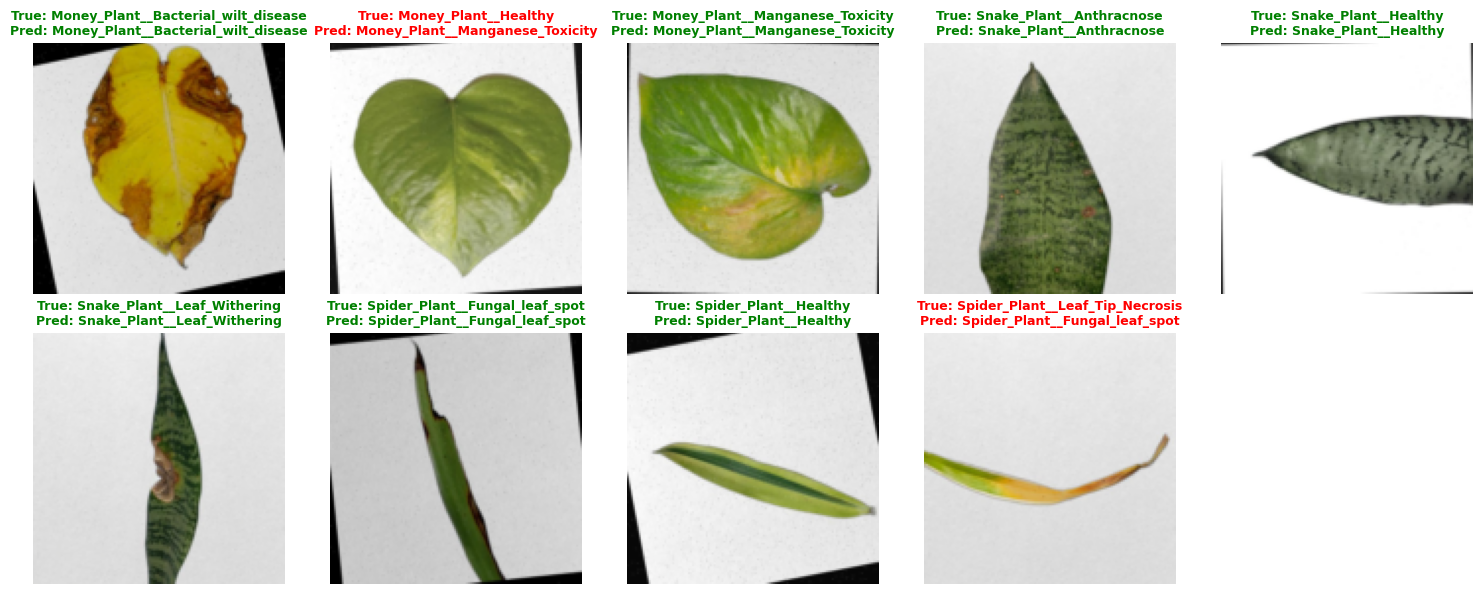

In [ ]:
# ==========================================
# BLOCK 9: MODEL 3 (RESNET50 TRANSFER LEARNING)
# ==========================================
def get_resnet_model(num_classes):
    print("Loading Pre-trained ResNet50...")
    # Load ResNet50 with default weights (ImageNet)
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Freeze layers (so we don't destroy pre-trained features)
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final "Head" (Fully Connected Layer)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

criterion = nn.CrossEntropyLoss()
# Initialize
model_3 = get_resnet_model(len(class_names)).to(DEVICE)
optimizer_3 = optim.Adam(model_3.fc.parameters(), lr=0.001)

# Train ResNet
history_3 = train_engine(model_3, train_loader, val_loader, criterion, optimizer_3, epochs=20, patience=3, model_name="Model 3 (ResNet)")
torch.save(model_3.state_dict(), "model_3_resnet.pth")
files.download("model_3_resnet.pth")

# EVALUATE
acc_3 = evaluate_model_performance(model_3, val_loader, class_names, "Model 3 (ResNet)")


Generating Confusion Matrix... (This might take a moment)


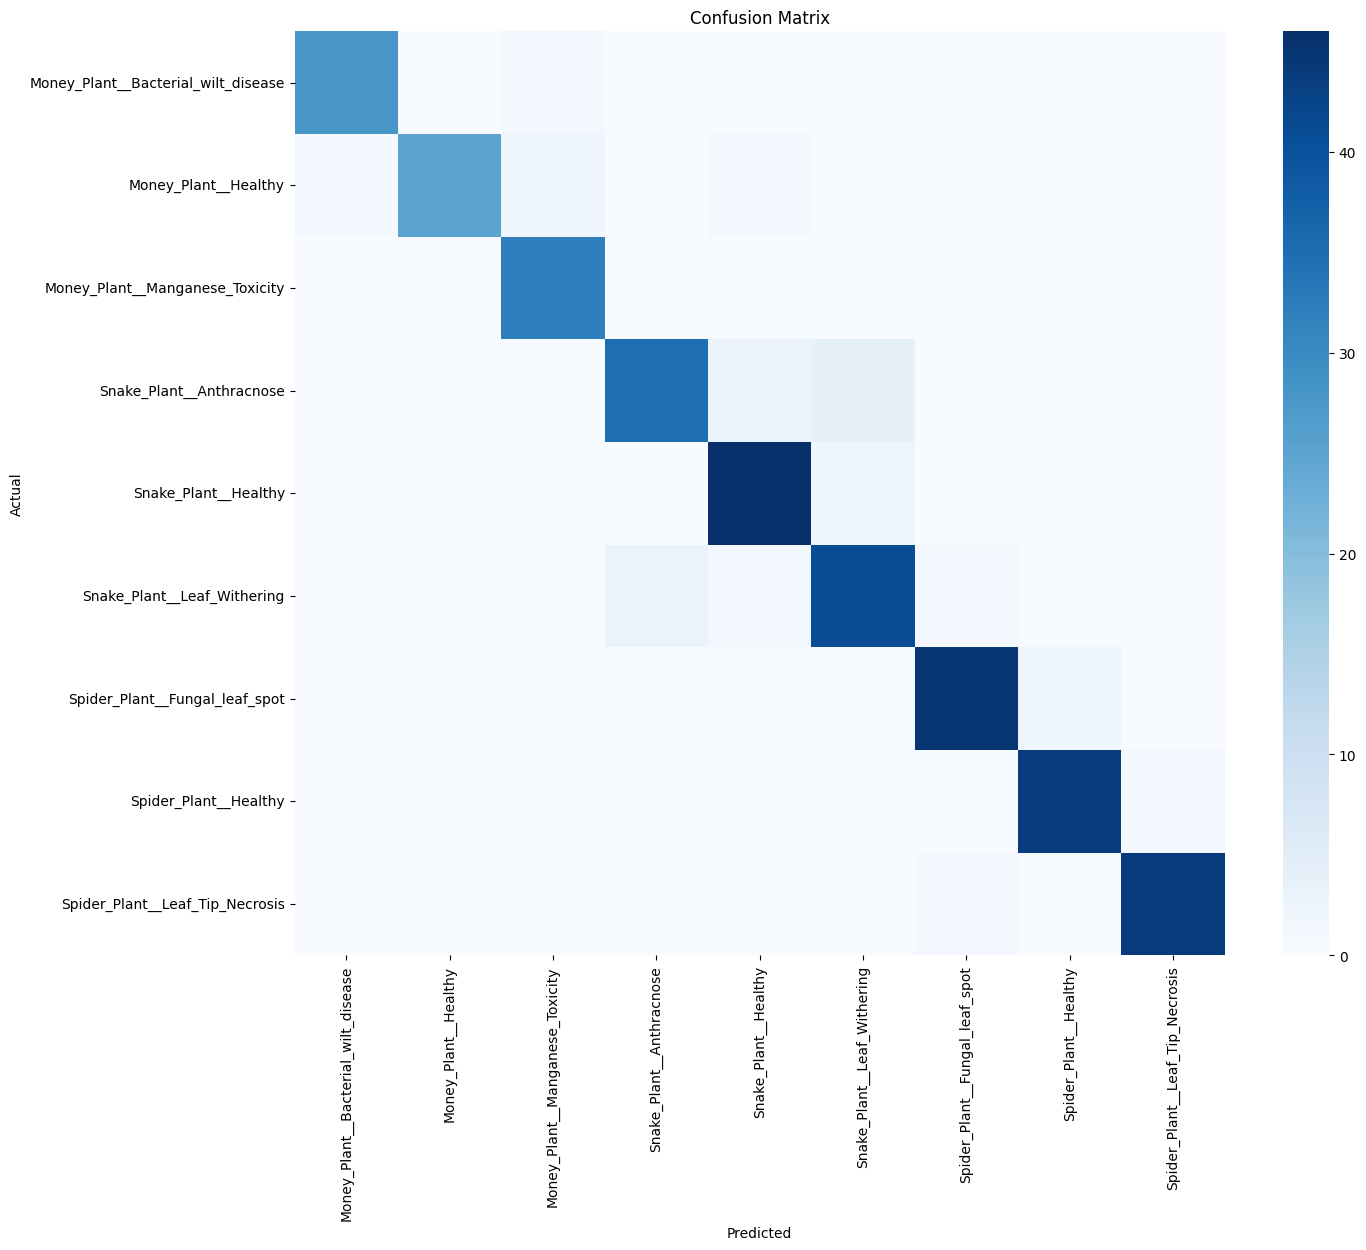

Generating Rogues Gallery (Visualizing Failures)...


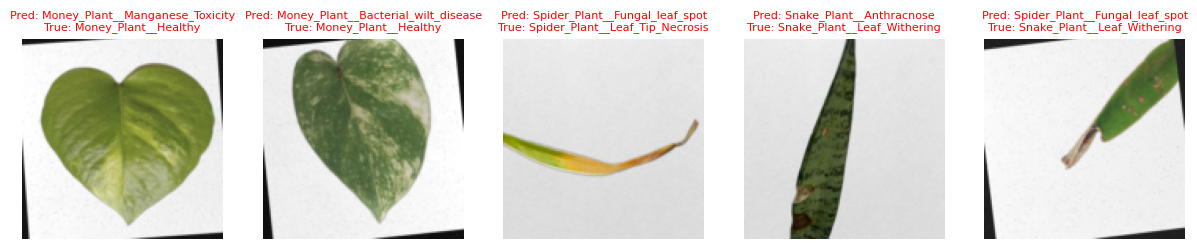

In [ ]:
# ==========================================
# BLOCK 10: VISUALIZATION & EVALUATION
# ==========================================
def plot_confusion_matrix(model, loader, classes):
    y_pred = []
    y_true = []
    model.eval()

    print("Generating Confusion Matrix... (This might take a moment)")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Calculate Matrix
    # labels=range(len(classes)) fixes the error if a class is missing in val set
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))

    # Plot
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

def rogues_gallery(model, loader, classes):
    print("Generating Rogues Gallery (Visualizing Failures)...")
    model.eval()
    failures = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Find errors in this batch
            wrong_idx = (preds != labels).nonzero()
            for idx in wrong_idx:
                if len(failures) < 5:
                    idx = idx.item()
                    failures.append((inputs[idx].cpu(), preds[idx].item(), labels[idx].item()))
            if len(failures) >= 5: break

    # Plot 5 failures
    plt.figure(figsize=(15, 5))
    for i, (img, pred, act) in enumerate(failures):
        # Un-normalize for display
        img = img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {classes[pred]}\nTrue: {classes[act]}", color='red', fontsize=8)
        plt.axis('off')
    plt.show()

# Run Visualization on the Best Model (ResNet)
plot_confusion_matrix(model_3, val_loader, class_names)
rogues_gallery(model_3, val_loader, class_names)

In [ ]:
# ==========================================
# BLOCK 11: FINAL COMPARISON
# ==========================================
final_results = {
    "Model 1 (Baseline)": history_1['val_acc'][-1],
    #"Model 2 (Optimized)": best_acc,
    "Model 3 (ResNet)": history_3['val_acc'][-1]
}

print("\n🏆 FINAL RESULTS 🏆")
print("-" * 40)
print(f"{'Model Name':<25} | {'Accuracy':<10}")
print("-" * 40)
for name, acc in final_results.items():
    print(f"{name:<25} | {acc:.2f}%")
print("-" * 40)


🏆 FINAL RESULTS 🏆
----------------------------------------
Model Name                | Accuracy  
----------------------------------------
Model 1 (Baseline)        | 71.90%
Model 3 (ResNet)          | 93.66%
----------------------------------------
